In [2]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

import numpy       as     np
import pandas      as     pd
import matplotlib.pyplot as plt
import matplotlib        as mpl
%matplotlib inline

In [3]:
from root_numpy import root2array

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestClassifier,RandomForestRegressor

# Plot settings
mpl.rcParams['legend.frameon' ] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize' ] = 18
mpl.rcParams['axes.labelsize' ] = 18
mpl.rcParams['lines.linewidth'] = 2.5

In [4]:
data = root2array('flatNtuple_4topSM.root')
df = pd.DataFrame(data)
cols = df.columns.tolist()
cols = cols[1:-1] + [cols[0]]
df = df[cols]
df.head()

,ht,njet,nbjet,nlep,met,met_phi,lep_pt0,lep_pt1,lep_pt2,lep_pt3,...,jet_isb0,jet_isb1,jet_isb2,jet_isb3,jet_isb4,jet_isb5,jet_isb6,jet_isb7,jet_isb8,m4top
0,363.195618,6,3,0,77.773085,1.056524,0.000000,0.000000,0.000000,0.0,...,0,0,1,1,0,1,0,0,0,1480.240498
1,739.406982,9,5,0,80.217866,-2.799677,0.000000,0.000000,0.000000,0.0,...,0,0,1,1,0,1,0,1,1,1279.838371
2,756.153748,9,5,1,51.067984,1.685508,125.348915,0.000000,0.000000,0.0,...,0,0,1,1,0,1,0,1,1,995.802801
3,708.742126,5,2,2,93.307299,3.023522,40.827286,169.840958,0.000000,0.0,...,0,0,1,1,0,1,0,1,1,1382.241903
4,567.742065,5,2,3,193.714731,2.289553,105.930557,25.705399,83.422684,0.0,...,0,0,1,1,0,1,0,1,1,2706.690433


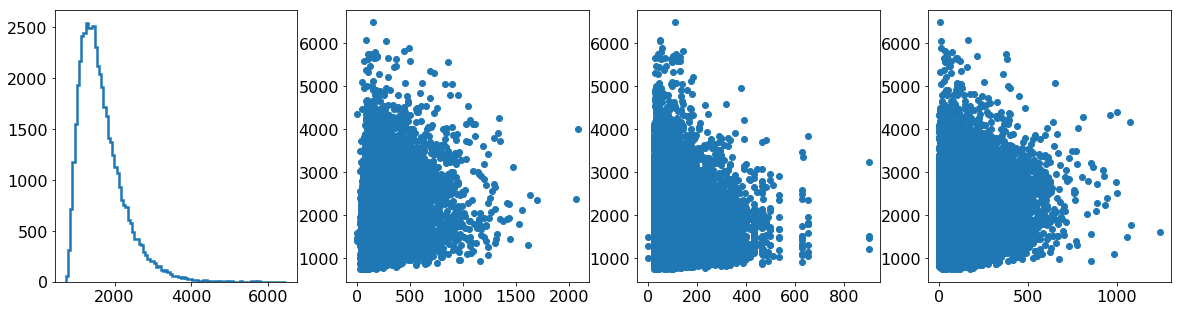

In [5]:
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.hist(df['m4top'], bins=100, histtype='step', linewidth=2.5)
plt.subplot(142)
plt.scatter(df['jet_pt1'],df['m4top'])
plt.subplot(143)
plt.scatter(df['lep_pt1'],df['m4top'])
plt.subplot(144)
plt.scatter(df['met'],df['m4top'])


In [7]:
#pd.plotting.scatter_matrix(df, figsize=(12,12), alpha=0.7, diagonal='hist')
#plt.tight_layout()
#plt.draw()

In [6]:
# Features and target
dataX = df.drop('m4top',axis=1)
dataY = df['m4top']

# Preparing cross validation samples
trainX, testX, trainY, testY = train_test_split(dataX, dataY, random_state=42, train_size=0.5)

In [7]:
rf_regre = RandomForestRegressor(n_estimators=500,n_jobs=-1).fit(trainX, trainY)

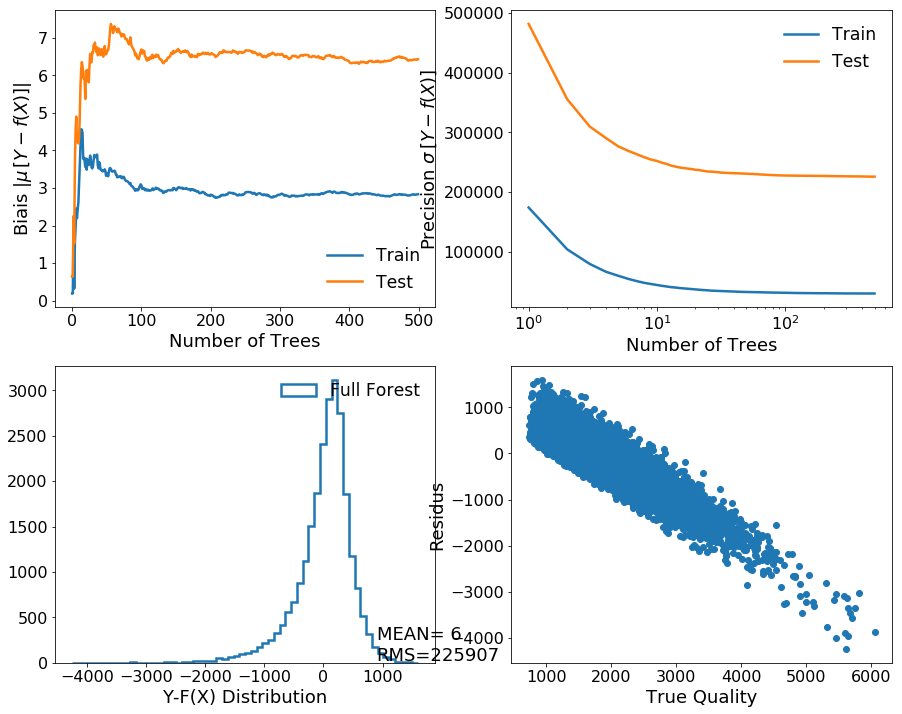

In [8]:
plt.figure(figsize=(15,12))

# 1. Check how the algorithm behaves with the number of trees
for sX, sY, label in [(trainX, trainY, 'Train'), (testX, testY, 'Test')]:
    predictions = np.zeros(len(sX))
    curve_rms   = []
    curve_mean  = []
    
    predictions = np.array( [tree.predict(sX) for tree in rf_regre.estimators_] )
    for i in range(0,rf_regre.n_estimators):
        if (i==0):
            Ypred=predictions[0]
        else:
            prediction_i = predictions[0:i]
            Ypred = np.average(prediction_i,axis=0)
            
        curve_rms .append( np.var(Ypred-sY) )
        curve_mean.append( np.abs(np.average(Ypred-sY)) )

    plt.subplot(221)
    plt.plot(curve_mean,label=label)
    plt.xlabel('Number of Trees')
    plt.ylabel('Biais $|\mu\,[Y-f(X)]|$')
    plt.legend()
    
    plt.subplot(222)
    plt.plot(curve_rms,label=label)
    plt.ylabel('Precision $\sigma\,[Y-f(X)]$')
    plt.xlabel('Number of Trees')
    plt.semilogx()
    plt.legend()

# 2. Plot the distribution for the final prediction    
Ypred = rf_regre.predict(testX)
Ytrue = testY
plt.subplot(223)
plt.xlabel('Y-F(X) Distribution')
plt.hist( Ypred-Ytrue ,bins=60, histtype='step', linewidth=2.5, label='Full Forest')
plt.text(900, 25, 'MEAN={:2.0f}\nRMS={:2.0f}'.format( np.average(Ypred-Ytrue), np.var(Ypred-Ytrue) ), fontsize=18)
plt.legend()

plt.subplot(224)
plt.xlabel('True Quality')
plt.ylabel('Residus')
plt.plot( Ytrue, Ypred-Ytrue, 'o')

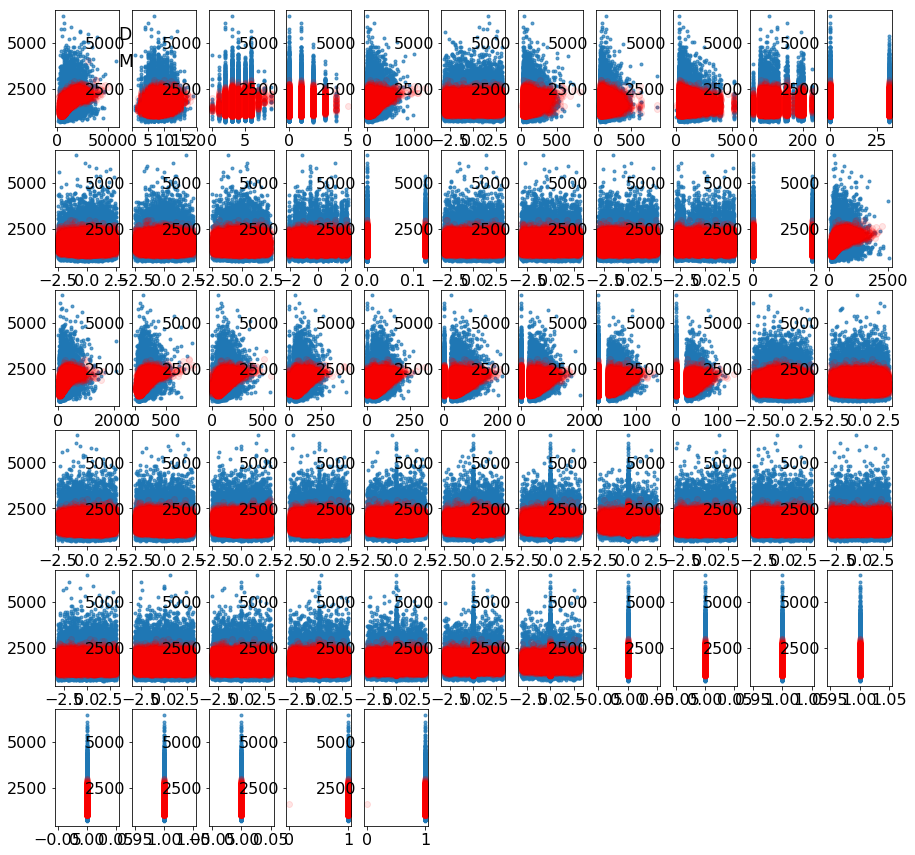

In [9]:
ymodel=rf_regre.predict(testX)

i=0
plt.figure(figsize=(15,15))
for varname in testX.columns:
    i=i+1
    x=testX[varname]
    plt.subplot(6,11,i)
    plt.plot(trainX[varname],trainY,'.',alpha=0.7, label='Data')
    plt.plot(testX[varname],ymodel,'ro',alpha=0.1,label='Model')  
    if (i==1):
        plt.legend()

(array([   3.,   10.,   20.,   37.,   59.,   89.,  134.,  185.,  229.,
         263.,  283.,  336.,  358.,  372.,  429.,  501.,  487.,  534.,
         519.,  566.,  552.,  555.,  572.,  519.,  589.,  602.,  599.,
         632.,  632.,  584.,  624.,  606.,  650.,  597.,  594.,  581.,
         522.,  571.,  534.,  530.,  463.,  485.,  456.,  460.,  411.,
         408.,  437.,  380.,  339.,  344.,  310.,  315.,  288.,  252.,
         249.,  234.,  192.,  204.,  172.,  177.,  162.,  132.,  126.,
         126.,  111.,   85.,   94.,   97.,   60.,   61.,   48.,   48.,
          35.,   28.,   23.,   20.,   21.,   10.,   14.,   13.,    8.,
           5.,    3.,    3.,    6.,    5.,    3.,    3.,    2.,    4.,
           0.,    1.,    2.,    0.,    0.,    2.,    0.,    1.,    1.,    1.]),
 array([ 1009.57512416,  1029.42488017,  1049.27463618,  1069.12439219,
         1088.9741482 ,  1108.82390421,  1128.67366022,  1148.52341623,
         1168.37317224,  1188.22292825,  1208.07268426,  1227.9224

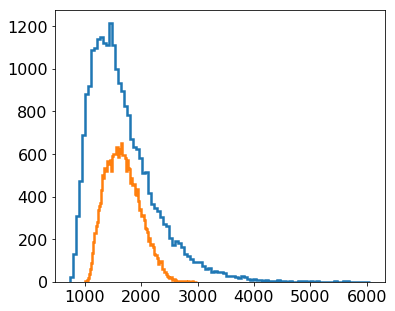

In [10]:
plt.figure(figsize=(13,5))
plt.subplot(121)
plt.hist(testY ,bins=100, histtype='step', linewidth=2.5)
plt.hist(ymodel,bins=100, histtype='step', linewidth=2.5)

In [42]:
from sklearn.ensemble    import AdaBoostRegressor
from sklearn.tree        import DecisionTreeRegressor
ab_clf = AdaBoostRegressor(n_estimators=1000, base_estimator=DecisionTreeRegressor(max_depth=5)).fit(trainX, trainY)

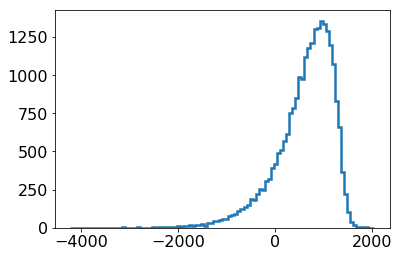

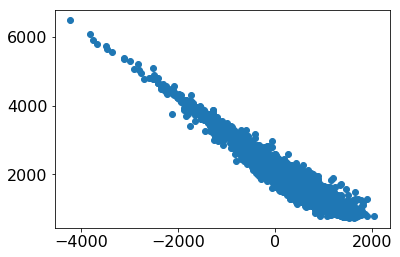

In [41]:
ymodel = ab_clf.predict(testX)
y      = trainY

plt.figure()
plt.hist(ymodel-y,bins=100, histtype='step', linewidth=2.5)

plt.figure()
plt.plot(ymodel-y,y,'o')

In [56]:
from sklearn.ensemble import GradientBoostingRegressor
gb_rege = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, max_depth=10).fit(trainX, trainY)

(array([   1.,    1.,    5.,   10.,   19.,   40.,   73.,  115.,  182.,
         218.,  293.,  391.,  455.,  507.,  543.,  640.,  624.,  661.,
         706.,  736.,  676.,  765.,  783.,  761.,  746.,  801.,  760.,
         751.,  774.,  703.,  726.,  721.,  616.,  634.,  586.,  568.,
         546.,  574.,  497.,  504.,  464.,  410.,  403.,  370.,  317.,
         323.,  309.,  275.,  220.,  219.,  225.,  199.,  164.,  161.,
         131.,  117.,  110.,   96.,   94.,   93.,   77.,   58.,   54.,
          52.,   46.,   46.,   32.,   36.,   31.,   22.,   25.,   16.,
          16.,   11.,   12.,    6.,    4.,    9.,    7.,    4.,    3.,
           2.,    4.,    4.,    1.,    1.,    2.,    2.,    0.,    1.,
           1.,    0.,    0.,    0.,    1.,    0.,    0.,    0.,    0.,    1.]),
 array([  807.42802816,   836.0590996 ,   864.69017105,   893.32124249,
          921.95231394,   950.58338538,   979.21445683,  1007.84552827,
         1036.47659972,  1065.10767117,  1093.73874261,  1122.3698

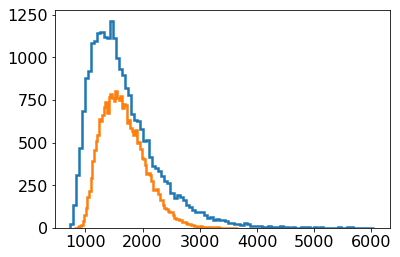

In [57]:
ymodel=gb_rege.predict(testX)
plt.figure()
plt.hist(testY , bins=100, histtype='step', linewidth=2.5)
plt.hist(ymodel, bins=100, histtype='step', linewidth=2.5)

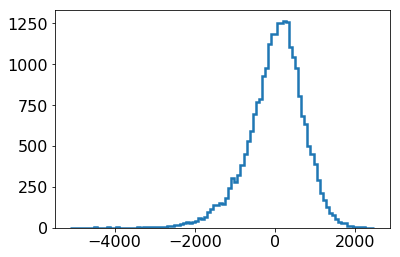

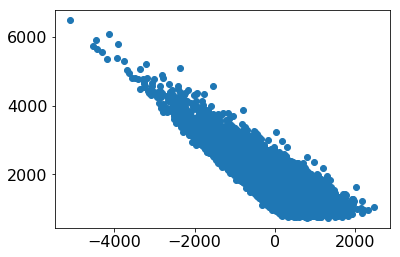

In [58]:
ymodel = gb_rege.predict(testX)
y = trainY

plt.figure()
plt.hist(ymodel-y,bins=100, histtype='step', linewidth=2.5)

plt.figure()
plt.plot(ymodel-y,y,'o')